In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

In [71]:
def extract_substances(dataframe):
    # Get the column names from the DataFrame
    columns = dataframe.columns

    # Create a dictionary to store the count of each unique substance
    substance_counts = {}

    # Extract unique substances from the column names and count occurrences
    for column in columns:
        # Split the column name based on the numeric part
        substance = ''.join([i for i in column if not i.isdigit()])
        
        # Update the count in the dictionary
        substance_counts[substance] = substance_counts.get(substance, 0) + 1

    # Convert the dictionary to two lists (substances and counts) and sort them
    unique_substances_list = sorted(list(substance_counts.keys()))
    counts_list = [substance_counts[substance] for substance in unique_substances_list]

    return unique_substances_list,counts_list

### FPCA for individual species

In [72]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [73]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
data = {s:pd.read_csv(r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s])) for s in specie}

In [74]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.013496,0.010313,0.006673,0.004786,0.185005,0.0,0.045759,0.0,0.0,...,0.0,0.027120,0.0,0.005985,0.0,0.017634,0.0,0.024239,0.027087,0.000000
1,0.004483,0.016588,0.010062,0.005755,0.004799,0.181456,0.0,0.038471,0.0,0.0,...,0.0,0.025385,0.0,0.005561,0.0,0.017054,0.0,0.028436,0.035160,0.000000
2,0.000000,0.014006,0.009641,0.005196,0.004684,0.180394,0.0,0.031634,0.0,0.0,...,0.0,0.024105,0.0,0.005051,0.0,0.015857,0.0,0.034271,0.039412,0.004712
3,0.000000,0.011910,0.009293,0.005245,0.004482,0.178462,0.0,0.027380,0.0,0.0,...,0.0,0.022787,0.0,0.004525,0.0,0.013629,0.0,0.039724,0.038390,0.005609
4,0.000000,0.010553,0.009516,0.005864,0.007022,0.178143,0.0,0.024033,0.0,0.0,...,0.0,0.021368,0.0,0.005905,0.0,0.013543,0.0,0.032204,0.038384,0.005814


In [75]:
#identify all used substances
substances,counts = extract_substances(data[[*data][0]])
substances,counts

(['Copper', 'Methomyl', 'Verapamil', 'Zinc'], [8, 7, 3, 4])

In [164]:
plot_colors = {'Copper':'#8c564b','Methomyl':'#9467bd','Verapamil':'#d62728','Zinc':'#e377c2'}
custom_palette = [plot_colors[s] for s in plot_colors]
sns.set_palette(custom_palette)
custom_palette

['#8c564b', '#9467bd', '#d62728', '#e377c2']

In [76]:
#Define columns and y values for functional data analysis
cols = data[[*data][0]].columns
y = ['{}'.format(s) for i,s in enumerate(substances) for x in range(counts[i])]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Verapamil',
 'Verapamil',
 'Verapamil',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

### Plot each data curve for each species

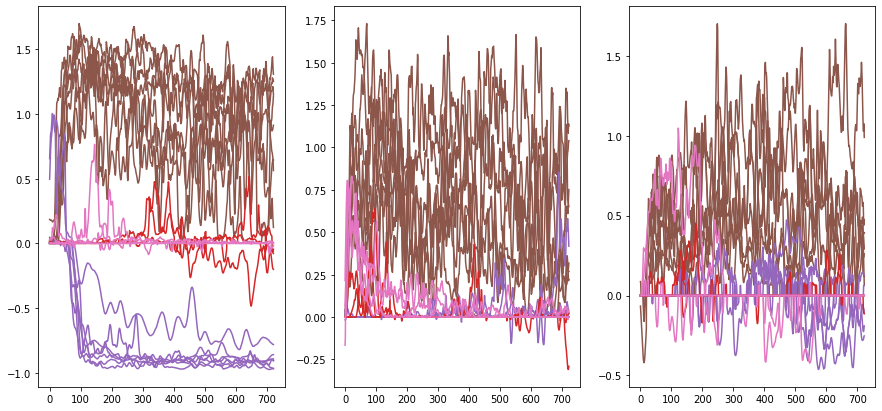

In [77]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    for x,col in enumerate(data[s].columns):
        axes[i].plot(data[s].index,data[s][col].values,color = plot_colors[y[x]])

### Import relevant Data Structures and convert to FD Data Grids and BSplines

In [78]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [135]:
#Define timestep for data and remove end data
timestep = 30
full_length = data[[*data][0]].shape[0]
#n_rows = (full_length//timestep)*timestep
n_rows = 360

In [136]:
#Cut dataframe at n_rows
for s in specie:
    data[s] = data[s].iloc[:n_rows]
    
data[s].shape

(360, 22)

In [137]:
#Apply tail filter to final half hour of data
def sigmoid(x):
    """
    Sigmoid function.
    """
    return 1 / (1 + np.exp(-x))

def smooth_tail_to_zero(arr, window_size=30*3):
    """
    Apply sigmoid filtering to the last 'window_size' values of a time series.

    Parameters:
    - time_series: Numpy array.
    - window_size: Number of values to apply the sigmoid filtering (default: 30).

    Returns:
    - Filtered time series.
    """
    # Copy arr to arr_filtered
    arr_filtered = arr.copy()

    # Extract the last 'window_size' values
    tail_values = arr[-window_size:]

    # Generate a reversed sigmoid function with the same length as the tail
    sigmoid_values = sigmoid(np.linspace(6, -6, window_size))

    # Apply reversed sigmoid filtering to the tail
    smoothed_tail = tail_values * sigmoid_values

    # Replace the tail in the original time series with the smoothed values
    arr_filtered[-window_size:] = smoothed_tail

    return arr_filtered


In [138]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.013496,0.010313,0.006673,0.004786,0.185005,0.0,0.045759,0.0,0.0,...,0.0,0.027120,0.0,0.005985,0.0,0.017634,0.0,0.024239,0.027087,0.000000
1,0.004483,0.016588,0.010062,0.005755,0.004799,0.181456,0.0,0.038471,0.0,0.0,...,0.0,0.025385,0.0,0.005561,0.0,0.017054,0.0,0.028436,0.035160,0.000000
2,0.000000,0.014006,0.009641,0.005196,0.004684,0.180394,0.0,0.031634,0.0,0.0,...,0.0,0.024105,0.0,0.005051,0.0,0.015857,0.0,0.034271,0.039412,0.004712
3,0.000000,0.011910,0.009293,0.005245,0.004482,0.178462,0.0,0.027380,0.0,0.0,...,0.0,0.022787,0.0,0.004525,0.0,0.013629,0.0,0.039724,0.038390,0.005609
4,0.000000,0.010553,0.009516,0.005864,0.007022,0.178143,0.0,0.024033,0.0,0.0,...,0.0,0.021368,0.0,0.005905,0.0,0.013543,0.0,0.032204,0.038384,0.005814


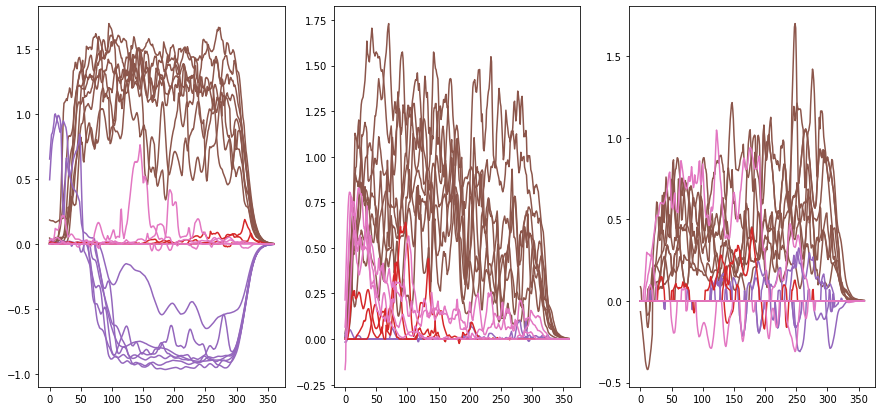

In [139]:
#Filter tail values if 'i' for igt in the filenames
for s in specie:
    df = data[s]
    for col in df.columns:
        df[col] = smooth_tail_to_zero(df[col].values)
    data[s] = df
    
#Check result in comparison
plot_colors = {'Copper':'#8c564b','Methomyl':'#9467bd','Verapamil':'#d62728','Zinc':'#e377c2'}
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    for x,col in enumerate(data[s].columns):
        axes[i].plot(data[s].index,data[s][col].values,color = plot_colors[y[x]])

In [140]:
#define FDA parameters
domain_range = (0,n_rows)
order = 4
knots = np.arange(0,n_rows+timestep,timestep)
n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330, 360])

In [141]:
np.arange(180,540+90,90)

array([180, 270, 360, 450, 540])

In [142]:
#define FDA parameters with uneven knots
domain_range = (0,n_rows)
order = 4

#define knots with uneven spacing
knots = np.hstack((np.array([0,60,120]),np.arange(180,n_rows+90,90)))

n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  60, 120, 180, 270, 360])

In [143]:
#define grid points and data matrices
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

#define functional data grids
fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

### Create basis functions

In [144]:
#create basis functions
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [145]:
X_bss = {s:fds[s].to_basis(bss) for s in specie}

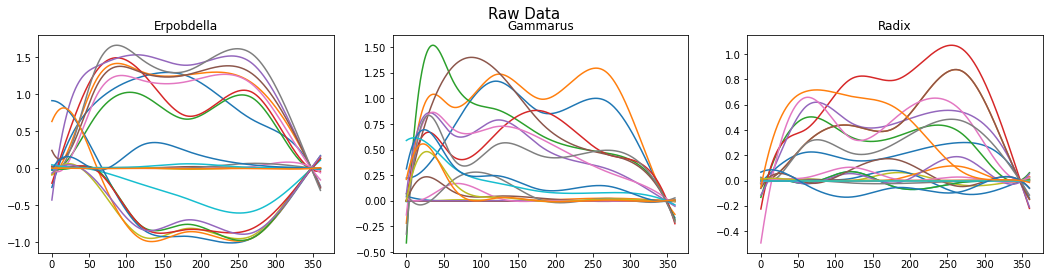

In [146]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

## FPCA

In [147]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [148]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

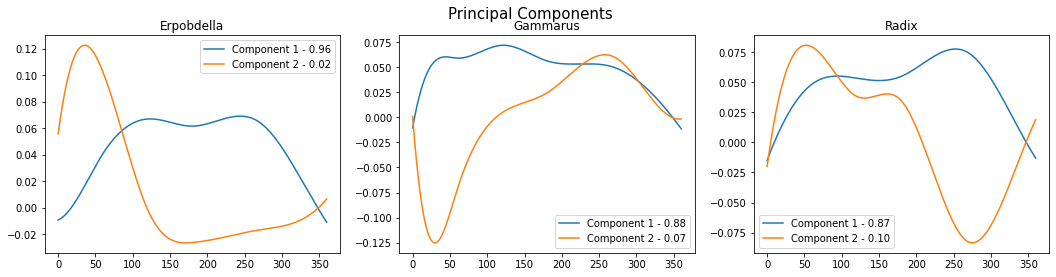

In [149]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Principal Components',fontsize = 15)
for i,s in enumerate(specie):
    fpcas[s].components_.plot(axes = axe[i])
    axe[i].legend(
        labels=['Component 1 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[0]),
                'Component 2 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[1])])
    axe[i].set_title(specie[s])

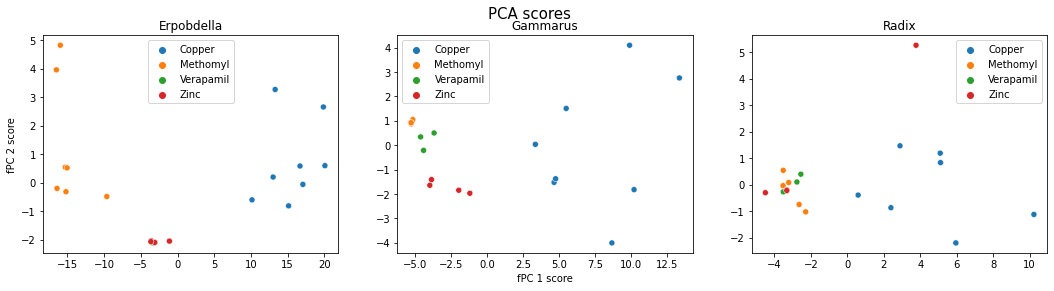

In [150]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

## MultiVector FDA

Whilst this is possible to create multidimensional Vector grids, their combination has not yet been achieved.

In [151]:
from skfda.representation.basis import VectorValuedBasis

In [152]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)

In [153]:
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

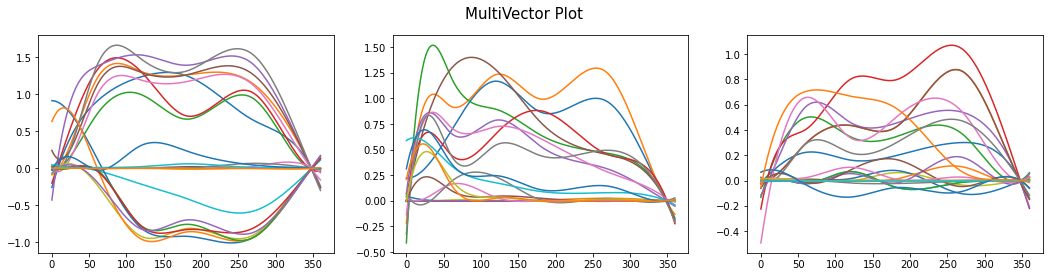

In [154]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

### What appears strange here is there is not exactly the same PCA for each domain 

Perhaps there is some kind of normalisation

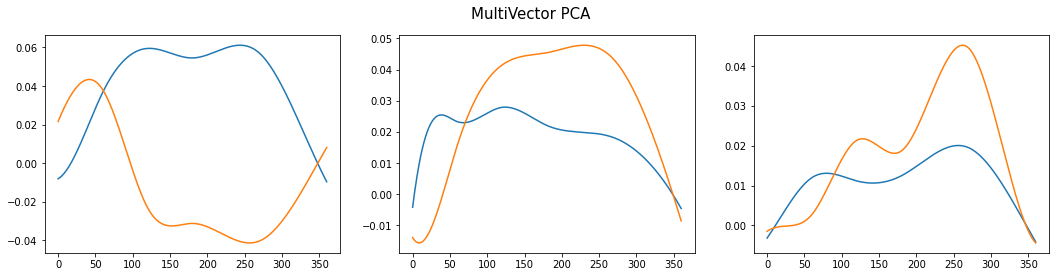

In [155]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [156]:
### Failed PCA plot attempt
scores = vector_fpca.fit_transform(vector_bss)
scores

array([[ 15.48890876,   2.76357648],
       [ 21.44300579,   5.61848565],
       [ 13.12558719,   0.7720366 ],
       [ 16.4462757 ,   4.93239552],
       [ 20.72717597,  -2.0861078 ],
       [ 20.61420535,   1.97013052],
       [ 16.53815498,  -1.61922976],
       [ 19.73694083,  -4.17584565],
       [-17.39260137,   1.93148111],
       [-11.47559548,  -0.74530932],
       [-17.0698804 ,   3.6088845 ],
       [-17.2708926 ,   4.02340632],
       [-16.49019315,   1.84452748],
       [-16.21104199,   1.75935695],
       [-16.08488383,   2.00274402],
       [ -5.38065453,  -3.49804336],
       [ -5.49249754,  -3.52625807],
       [ -5.09140431,  -3.30801285],
       [ -5.45542848,  -3.74819732],
       [ -4.29421255,  -3.00525479],
       [ -2.49810783,  -3.81108445],
       [ -3.91286052,  -1.70368177]])

In [157]:
scores_fp1 = scores[:,0]
scores_fp2 = scores[:,1]
scores_fp1

array([ 15.48890876,  21.44300579,  13.12558719,  16.4462757 ,
        20.72717597,  20.61420535,  16.53815498,  19.73694083,
       -17.39260137, -11.47559548, -17.0698804 , -17.2708926 ,
       -16.49019315, -16.21104199, -16.08488383,  -5.38065453,
        -5.49249754,  -5.09140431,  -5.45542848,  -4.29421255,
        -2.49810783,  -3.91286052])

In [158]:
positive_scores = scores[scores>0]
negative_scores = -scores[scores<0]

log_positive_scores = np.log(1+positive_scores)
log_negative_scores = np.log(1+negative_scores)

log_scores = np.empty_like(scores)
log_scores[scores>0] = log_positive_scores
log_scores[scores<0] = -log_negative_scores

log_scores

array([[ 2.80268796,  1.3253697 ],
       [ 3.11097902,  1.88986659],
       [ 2.64798785,  0.5721295 ],
       [ 2.8591262 ,  1.7804281 ],
       [ 3.07856383, -1.12691069],
       [ 3.07335075,  1.0886059 ],
       [ 2.86437879, -0.96288029],
       [ 3.03191669, -1.64400274],
       [-2.91194848,  1.07550779],
       [-2.52377437, -0.5569318 ],
       [-2.89424649,  1.52798585],
       [-2.90530923,  1.61410825],
       [-2.86164033,  1.04539697],
       [-2.84555115,  1.01499766],
       [-2.83819409,  1.09952654],
       [-1.85327068, -1.50364249],
       [-1.87064729, -1.50989556],
       [-1.80687865, -1.46047674],
       [-1.8649214 , -1.55776503],
       [-1.66661425, -1.3876072 ],
       [-1.2522222 , -1.57092252],
       [-1.59185636, -0.99461446]])

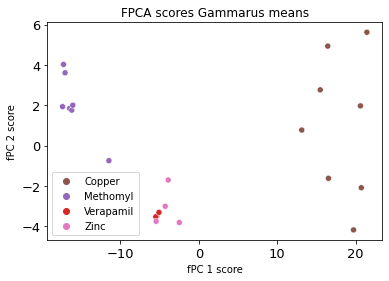

In [163]:
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Gammarus means")

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()

# Clustering

**Clustering methods should be fed the smoothed data not the basis data - it must be loaded in**

In [54]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot
)
from skfda.ml.clustering import FuzzyCMeans,KMeans

## Single basis clusters

In [55]:
#Clustering unsupervised (except no. clusters)
n_clusters = 4
seed = 0

kmeans = {s:KMeans(n_clusters = n_clusters, random_state = seed).fit(X_bss[s].to_grid()) for s in specie}
for s in specie:
    print('Kmeans prediction: {}'.format(specie[s]))
    print(kmeans[s].predict(X_bss[s].to_grid()))

Kmeans prediction: Erpobdella
[0 0 0 0 0 0 0 0 2 2 1 1 2 1 2 3 3 3 3 3 3 3]
Kmeans prediction: Gammarus
[1 1 1 1 1 1 1 1 0 2 0 0 0 3 2 1 0 1 0 0 0 0]
Kmeans prediction: Radix
[0 1 2 1 2 1 1 1 3 3 0 3 3 3 3 0 3 3 3 3 0 2]


In [57]:
vector_kmean = KMeans(n_clusters = 4, random_state = seed).fit(vector_bss.to_grid())
vector_kmean.predict(vector_bss.to_grid())

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 2, 1, 3, 1, 3, 3, 3, 3])